#  <center> Hyperparameter Tuning with Bayesian Optimization </center>

⭐ This notebook introuduces you to a very useful **hyperparameter tuning** technique: **`Bayesian Optimization`**. I will walk you through an example of tuning a **LightGBM** model using the **Scikit-optimize** library.

❗ If you are not familiar with **LightGBM**, feel free to check out this [notebook](https://www.kaggle.com/code/ryanluoli2/a-complete-guide-to-boosting-methods) which provides you with an comprehensive introduction to **boosting methods**.

🙏 Thanks to this great [notebook](https://www.kaggle.com/code/lucamassaron/scikit-optimize-for-lightgbm/notebook) and the Kaggle Book!

## Hyperparameter Tuning

Tuning hyperparamters is to find the **best set of hyperparameters** (within a **search space**) that will minimize the **loss function**.

This is an **optimization problem** where the **shape** of the objective function is unknown but we can only **evaluate** the function at different **points** (sets of hyperparameters). 

The most straight forward approach is to simply **try all the possible combinations** (grid search) of hyperparameters and pick the best performing one. However, this is **not feasible** in most cases as training and evaluating a model is **time consuming**.

Therefore, **`Bayesian Optimization`** (BO) comes into the play which helps us **make clearly decisions** on what sets of hyperparameters to evaluate.

## Bayesian Optimization

The key idea behind BO is that we **recapitulate** the true objective function (**loss function**) with a **surrogate function** and transfer the problem onto optimizing an **acquisition function**.

Let me explain what this means:

Think of hypoerparameter tuning as optimizing a **black-box function** whose shape is unknown. However, we can evaluate the function at **different points** and fit a **`surrogate function`** through the points trying to model the objective function. For example, a very commonly used surrogate function is called the **`Gaussian Process`**:

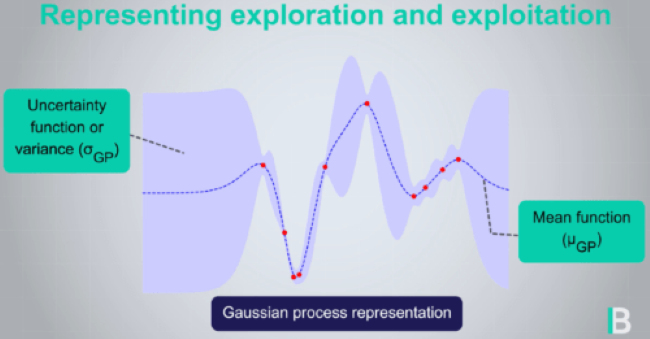

We **continuously update** our surrogate function as more points are being evaluated so it becomes **closer and closer** to the true objective function. As you can see in the above diagram, areas that have not been **explored** (few points evaluated) will have high uncertainty and we are more certain about the areas that have been **exploited** (many points evaluated).

Then, we obtain an **`acquisition function`** from the surrogate model that tells us **how promising** it is to evaluate a certain point. Now, we only have to **optimize** this acquisition function to decide which point to evaluate next:

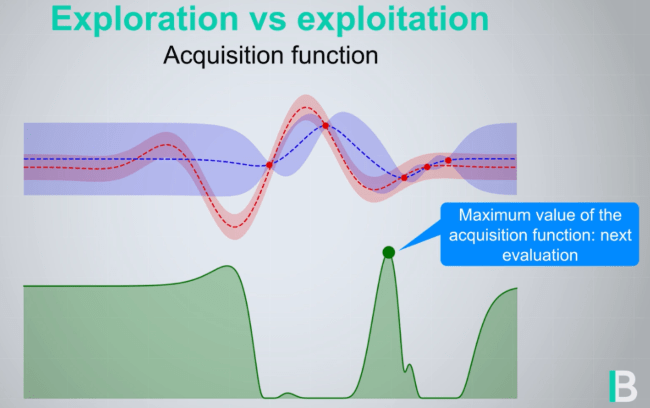

We use this acquisition function to balance between **exploration** (evaluate areas with high uncertainty) and **exploitation** (evaluate areas that we think is promising). To model this **trade-off**, we can use an acquisition function like the following:

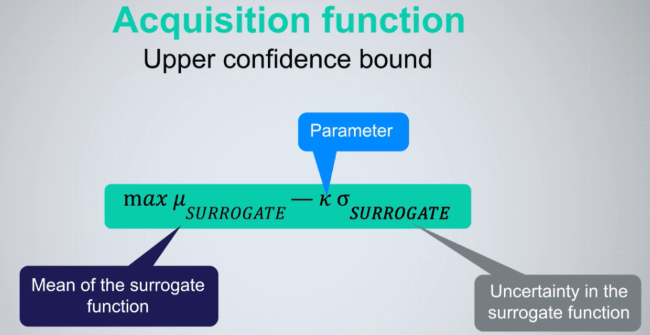

We repeat the following process:

1. evaluate a point on the objective function
2. update the surrogate function
3. update the acquistioin function
4. optimize the acquistioin function
5. evaluate the next point...

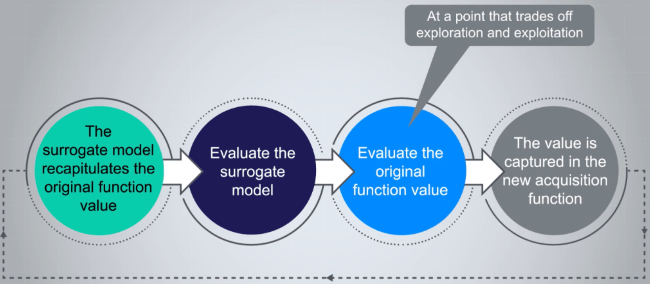

As we repeat the above process, the **acquisition function** will become more and more **pointy** indicating that the algorithm thinks that it has found the **approximate location of the optimal solution** and are starting to **exploit** the area with **no more exploration**. We **stop the process** until there are **no significant improvement** observed over a number of repeatitions.

## Import Data

In this notebook, we are use the data from this competition [House Prices - Advanced Regression Techniques](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques).

(I have done some **preprocessing** to clean the data before we use it!)

In [23]:
import numpy as np
import pandas as pd

import pprint
from time import time
from datetime import datetime
from functools import partial

import lightgbm as lgb

from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
#import the cleaned training and test data
X_train = pd.read_csv('../input/cleaned-train-x/cleaned_train_X.csv')
y_train = pd.read_csv('../input/cleaned-train-y/cleaned_train_y.csv')

If you would like to carry out the **data preprocessing** part yourself, you can import the **raw data** like this:

In [ ]:
#the raw data can be imported as following
df_train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
df_test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

We use **root-mean-squared-error** (rmse) as our evaluation metric for this task:

In [3]:
#define the evaluation metric as 5-fold cross-validation root-mean-square-error
def rmsle_cv(model):
    kf = KFold(5, shuffle=True, random_state=0).get_n_splits(X_train.values)
    rmse = np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv=kf))
    return rmse

## Hyperparameter Tuning with Scikit-optimize

In [5]:
#uncomment and run the following code if you need to install the package
#pip install scikit-optimize

In [4]:
from skopt import BayesSearchCV
from skopt.utils import use_named_args 
from skopt import gp_minimize, forest_minimize
from skopt import gbrt_minimize, dummy_minimize
from skopt.space import Real, Categorical, Integer
from skopt.callbacks import DeadlineStopper, DeltaYStopper

We first define a **`reporting function`** that can be used by Scikit-optimize for various optimization tasks.

The function takes the **data** and the **optimizer** as inputs. It can also handle **callback functions**, which are functions that perform actions such as **reporting**, **early stopping** based on having reached a certain threshold of time spent searching or performance not improving, or **saving the state** of the processing after each optimization iteration:

In [6]:
def report_perf(optimizer, X, y, title="model", callbacks=None):
    """
    A wrapper for measuring time and performance of optimizers.
    optimizer = a sklearn or a skopt optimizer
    X = the training set
    y = the taget variable
    title = a string label for the experiment
    """
    start = time()
    
    if callbacks:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X,y)
    
    end = time()
        
    results = pd.DataFrame(optimizer.cv_results_)
    best_score = optimizer.best_score_
    best_score_std = results.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_   
    
    print((title + " took %.2f seconds, candidates checked: %d, best CV score: %.3f" + u" \u00B1"+" %.3f") %
    (end - start, len(optimizer.cv_results_['params']), best_score, best_score_std))
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    
    return best_params

We now have to prepare the **scoring function**, the **validation strategy**, the **model**, and the **search space**:

In [17]:
scoring = make_scorer(partial(mean_squared_error, squared=False), greater_is_better=False)

kf = KFold(n_splits=5, shuffle=True, random_state=0)

reg = lgb.LGBMRegressor(boosting_type = 'gbdt',
                        objective = 'regression',
                        metric = 'rmse',
                        n_jobs = 1,
                        verbose = -1,
                        random_state = 0)

Setting the **search space** requires the use of different functions from Scikit-optimize, such as **Real**, **Integer**, or **Choice**.

Each function samples from a **different kind of distribution** that you define as a parameter (usually the **uniform** distribution, but the **log-uniform** is also used when you are more interested in the **scale effect** of a parameter than its exact value):

In [18]:
search_spaces = {
    'learning_rate': Real(0.01, 1.0, 'log-uniform'),     # Boosting learning rate
    'n_estimators': Integer(30, 5000),                   # Number of boosted trees to fit
    'num_leaves': Integer(2, 512),                       # Maximum tree leaves for base learners
    'max_depth': Integer(-1, 256),                       # Maximum tree depth for base learners, <=0 means no limit
    'min_child_samples': Integer(1, 256),                # Minimal number of data in one leaf
    'min_child_weight': Real(0.01, 10.0, 'uniform'),     # Minimum sum of instance weight
    'max_bin': Integer(100, 1000),                       # Max number of bins buckets
    'subsample': Real(0.01, 1.0, 'uniform'),             # Subsample ratio of the training instance
    'subsample_freq': Integer(0, 10),                    # Frequency of subsample, <=0 means no enable
    'colsample_bytree': Real(0.01, 1.0, 'uniform'),      # Subsample ratio of columns when constructing each tree
    'reg_lambda': Real(1e-9, 100.0, 'log-uniform'),      # L2 regularization
    'reg_alpha': Real(1e-9, 100.0, 'log-uniform'),       # L1 regularization
   }

Now, we feed all the above into your optimization function, **`BayesSearchCV`**. 

You can set a **maximum number of iterations** performed, the kind of **surrogate function** (**Gaussian processes** works on most occasions), and the **random seed** for reproducibility:

In [19]:
opt = BayesSearchCV(estimator = reg,                                    
                    search_spaces = search_spaces,                      
                    scoring = scoring,                           
                    cv = kf,                                           
                    n_iter = 60,                                  # max number of trials
                    n_points = 3,                                 # number of hyperparameter sets evaluated at the same time
                    n_jobs = -1,                                  # number of jobs
                    return_train_score = False,                         
                    refit = False,                                      
                    optimizer_kwargs = {'base_estimator': 'GP'},  # optmizer parameters: we use Gaussian Process
                    random_state = 0)                             # random state for replicability

In [20]:
overdone_control = DeltaYStopper(delta=0.0001)                 # We stop if the gain of the optimization becomes too small
time_limit_control = DeadlineStopper(total_time=60*30)         # We impose a time limit (30 minutes)
best_params = report_perf(opt, X_train, y_train, 'LightGBM_regression', 
                          callbacks=[overdone_control, time_limit_control])

LightGBM_regression took 326.77 seconds, candidates checked: 60, best CV score: -0.123 ± 0.020
Best parameters:
OrderedDict([('colsample_bytree', 0.2801772863015679),
             ('learning_rate', 0.018361862613756427),
             ('max_bin', 563),
             ('max_depth', 232),
             ('min_child_samples', 14),
             ('min_child_weight', 9.09418529590311),
             ('n_estimators', 947),
             ('num_leaves', 505),
             ('reg_alpha', 0.0009168150882046735),
             ('reg_lambda', 0.18253962681965613),
             ('subsample', 0.6737101592760297),
             ('subsample_freq', 10)])



Now you have found the **'best' set** (not excatly the best because we set a time limit) of hyperparameters, let's see whether using these hyperparameters will imporve the model's performance:

In [21]:
# model with default hyperparameters
reg = lgb.LGBMRegressor(boosting_type = 'gbdt',
                        objective = 'regression',
                        metric = 'rmse',
                        n_jobs = 1,
                        verbose = -1,
                        random_state = 0)

# model with the tuned hyperparameters
reg_best = lgb.LGBMRegressor(boosting_type = 'gbdt',
                             objective = 'regression',
                             metric = 'rmse',
                             n_jobs = 1, 
                             verbose = -1,
                             random_state = 0,
                             **best_params)

In [24]:
print('5-Flod Cross-Validation score: (smaller the better):\n')

lgb_score = rmsle_cv(reg)
print(f"LightGBM before tuning = {round(lgb_score.mean(),3)} ({round(lgb_score.std(),3)})")

lgb_best_score = rmsle_cv(reg_best)
print(f"LightGBM after tuning = {round(lgb_best_score.mean(),3)} ({round(lgb_best_score.std(),3)})")

5-Flod Cross-Validation score: (smaller the better):

LightGBM before tuning = 0.131 (0.009)
LightGBM after tuning = 0.124 (0.01)


🎉🎉🎉 Yeah! We have a better model now!